# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

Femke Geens - 0544174 - VUB

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy
import math

from scipy.special import comb
from scipy.interpolate import interp1d

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

# Figure 1
To successfully replicate figures 1.A. and 1.B., we construct the environment of the N-person Hawk-Dove Game. For this particular game, we analyze the environment for infinite populations.

In [ ]:
R = 1.0
N = 5

n_steps = 1000

In [ ]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D

In [ ]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness

# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)

Next, we generate the results to obtain figure 1.A.. This figure illustrates the gradient of selection for different frequencies of doves in the population. To do this for infinite populations, we repeatedly take a sample of size N and perform our calculations using this sample. In this case the sample size is 5. The gradient is displayed for varying hawk costs. This enables us to reason about the stability of the doves in the population when hawks are punished to a varying degree.

In [ ]:
c_h_results = np.empty((3, n_steps))
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for index, c_h in enumerate([0.1, 0.5, 0.9]):

    x_dot = np.empty(n_steps)

    for i in range(len(hawk_cost)):
        x = hawk_cost[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

    c_h_results[index] = x_dot

Further, we generate the data to correctly reproduce figure 1.B.. To obtain these results, we explore the different frequencies of doves to find where the population reaches an equilibrium for increasing hawk costs. We repeat this for different sample sizes 5, 10, 20, 50, and 100 to see how the equilibria shift.

In [ ]:
import statistics

dove_fractions = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))
PRECISION = 1e-03

for i_N, N in enumerate(N_values):
    equilibria_N = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        eq_fraction = []
        x_dot = np.empty(n_steps)

        for i in range(len(dove_fractions)):
            x = dove_fractions[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

            if abs(fitness_doves - fitness_hawks) < PRECISION:
                eq_fraction.append(x)
                if x != 0.0:
                     break

        if 0 in eq_fraction:
            eq_fraction.remove(0)
        if (n_steps - 1) in eq_fraction:
            eq_fraction.remove((n_steps - 1))
        if eq_fraction:
            equilibria_N.append(statistics.median(eq_fraction))
        else:
             equilibria_N.append(np.nan)

    eq_results[i_N] = equilibria_N

Now, we plot figure 1.A. and figure 1.B. next to each other to successfully replicate figure 1 from the paper.

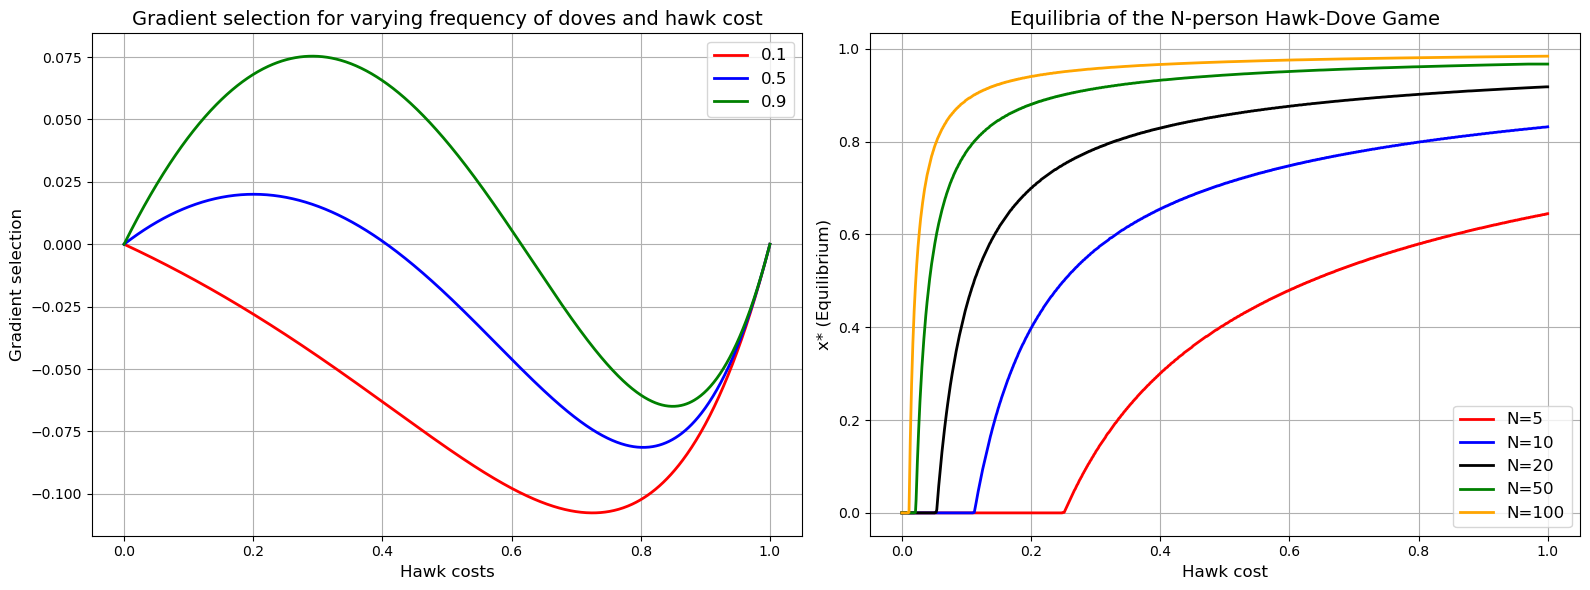

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First Plot
labels_1 = ["0.1", "0.5", "0.9"]
colors_1 = ["red", "blue", "green"]

for i, values in enumerate(c_h_results):
    axes[0].plot(hawk_cost, values, label=labels_1[i], color=colors_1[i], linewidth=2)

axes[0].set_xlabel("Hawk costs", fontsize=12)
axes[0].set_ylabel("Gradient selection", fontsize=12)
axes[0].set_title("Gradient selection for varying frequency of doves and hawk cost", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# Second Plot
labels_2 = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors_2 = ["red", "blue", "black", "green", "orange"]

for i, values in enumerate(eq_results):
    x = np.linspace(0, 1, num=len(values), dtype=np.float64)
    first_valid_index = np.where(~np.isnan(values))[0][0]
    values[:first_valid_index] = 0

    valid = ~np.isnan(values)
    interp_func = interp1d(x[valid], values[valid], kind='linear', fill_value="extrapolate")
    values[~valid] = interp_func(x[~valid])

    axes[1].plot(x, values, label=labels_2[i], color=colors_2[i], linewidth=2)

axes[1].set_xlabel("Hawk cost", fontsize=12)
axes[1].set_ylabel("x* (Equilibrium)", fontsize=12)
axes[1].set_title("Equilibria of the N-person Hawk-Dove Game", fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Figure 2
To replicate figure 2, we change the environment to simulate a finite population of hawks and doves. We start off by defining the required parameters for figure 2.A..

In [ ]:
def gradient_of_selection(k, Z, c_H, N, w):

    fraction = k/Z
    f_d = average_fitness_doves(N, fraction)
    f_h = average_fitness_hawks(N, (1-fraction), c_H)

    T_plus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_d - f_h))))
    T_minus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_h - f_d))))

    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):

    k_values = np.arange(Z + 1)
    g_values = np.empty(len(k_values))

    for i, k in enumerate(k_values):
        g_values[i] = gradient_of_selection(k, Z, c_H, N, w)

    X_as = k_values / Z

    return X_as, g_values

Next, we define the functions to generate the results for figure 2.B.

In [ ]:
def calculate_gradients_figure_2B(Z, N, w):
    eq = []
    PRECISION = 1e-05
    for index, c_H in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)

        eq_c_h = []

        for i, gradient in enumerate(g_values):
            if gradient < PRECISION:
                frequency = X_as[i]
                eq_c_h.append(frequency)
                if frequency != 0.0:
                    break

        if 0 in eq_c_h:
            eq_c_h.remove(0)
        if (n_steps - 1) in eq_c_h:
            eq_c_h.remove((n_steps - 1))
        if eq_c_h:
            eq.append(statistics.median(eq_c_h))
        else:
             eq.append(np.nan)

    return eq

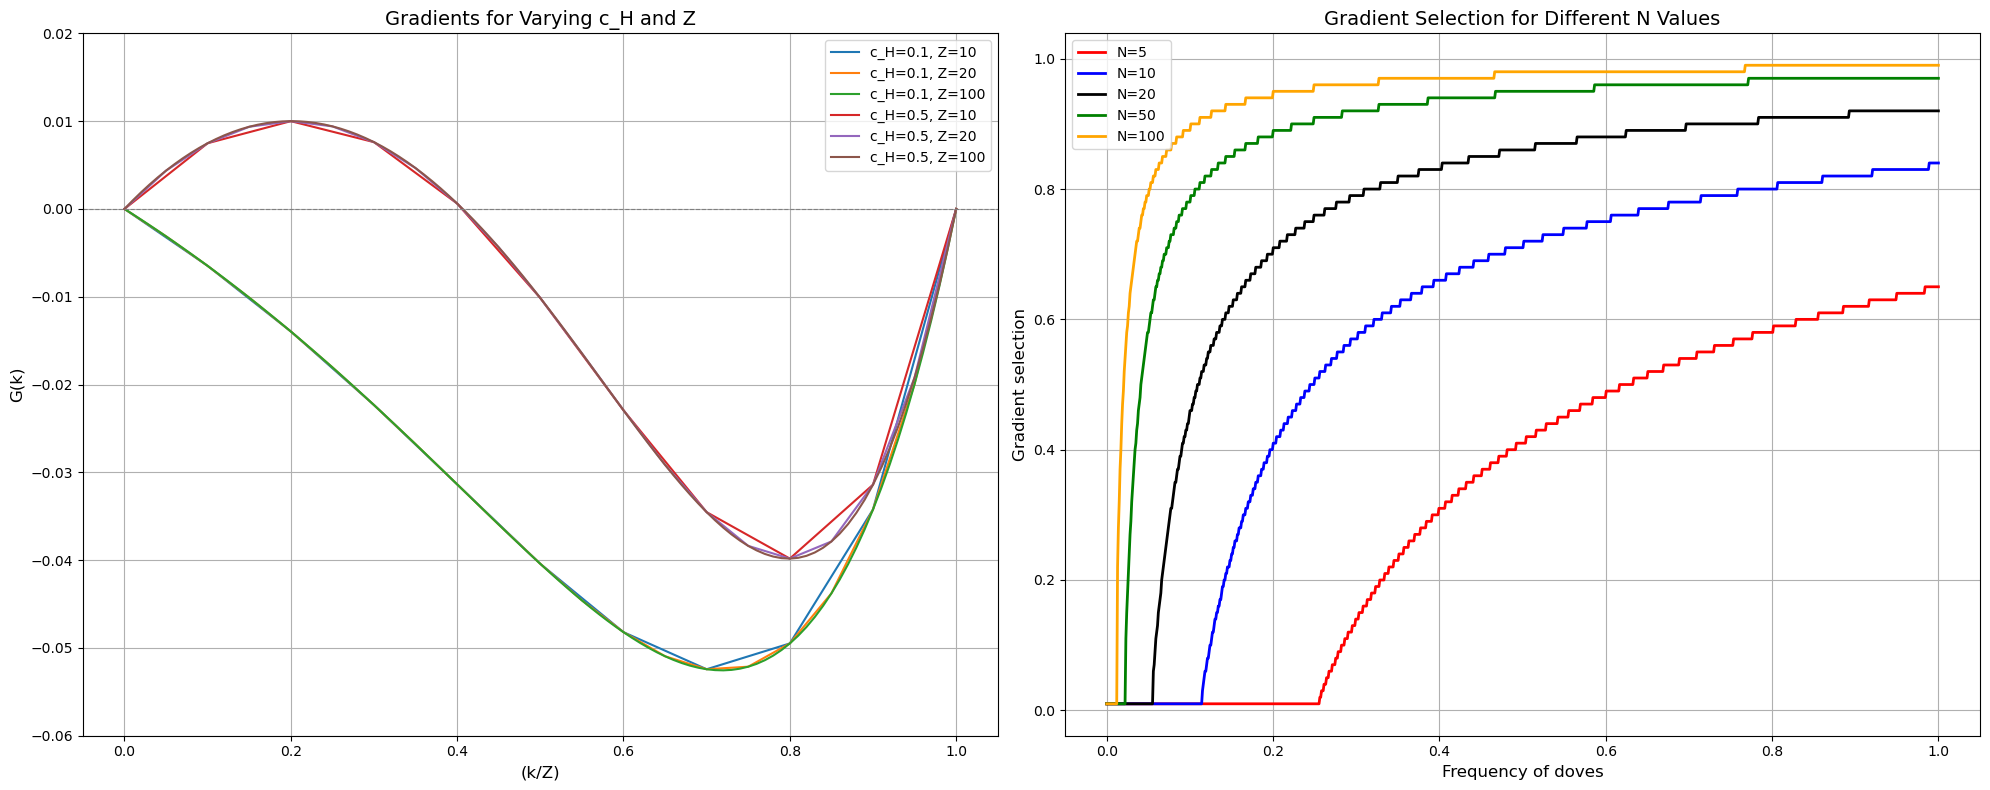

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

R = 1
N = 5
c_H_values = [0.1, 0.5]
Z_values = [10, 20, 100]
w = 1

# First Plot
for c_H in c_H_values:
    for Z in Z_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        axes[0].plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

# Plot details for the first plot
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_xlabel("(k/Z)", fontsize=12)
axes[0].set_ylim(-0.06, 0.02)
axes[0].set_ylabel("G(k)", fontsize=12)
axes[0].set_title("Gradients for Varying c_H and Z", fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid()

# Second Plot
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]
N_values = [5, 10, 20, 50, 100]

Z = 100
R = 1
w = 1
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for i, N in enumerate(N_values):
    values = calculate_gradients_figure_2B(Z, N, w)
    axes[1].plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

# Plot details for the second plot
axes[1].set_xlabel("Frequency of doves", fontsize=12)
axes[1].set_ylabel("Gradient selection", fontsize=12)
axes[1].set_title("Gradient Selection for Different N Values", fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Figure 3

In [ ]:
# Parameters
N = 5
R = 1.0

In [ ]:
# Payoff hawks
def P_H_T(amount_hawks, c_h, T, N):
    P_H = 0
    total_hawks= amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N < T:
        P_H = (R - (amount_hawks*c_h)) / total_hawks
    return P_H

# Payoff doves
def P_D_T(amount_hawks, c_d,  T, N):
    P_D = 0
    total_hawks = amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N >= T:
        P_D = (R - (total_hawks * c_d)) / amount_doves
    return P_D

In [ ]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H_T(i, c_h, T, N)
    return average_fitness

# Fitness doves
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D_T(i, c_d, T, N)
    return average_fitness

In [ ]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

In [ ]:
def figure3A(T, c_d):

    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []


    for index, c_h in enumerate(hawk_cost):

        x_dot = np.empty(n_steps)

        for i in range(len(dove_frequency)):
            x = dove_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x * (1 - x) * (fitness_hawks - fitness_doves)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        hawk_cost_answer.extend([c_h] * len(equilibria))

    return fraction_dove, hawk_cost_answer


def figure3B(T, c_h):

    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    fraction_dove_answer = []

    for index, c_d in enumerate(dove_cost):

        x_dot =  np.empty(n_steps)

        for i in range(len(dove_frequency)):
            x = dove_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        fraction_dove_answer.extend([c_d] * len(equilibria))

    return fraction_dove, fraction_dove_answer

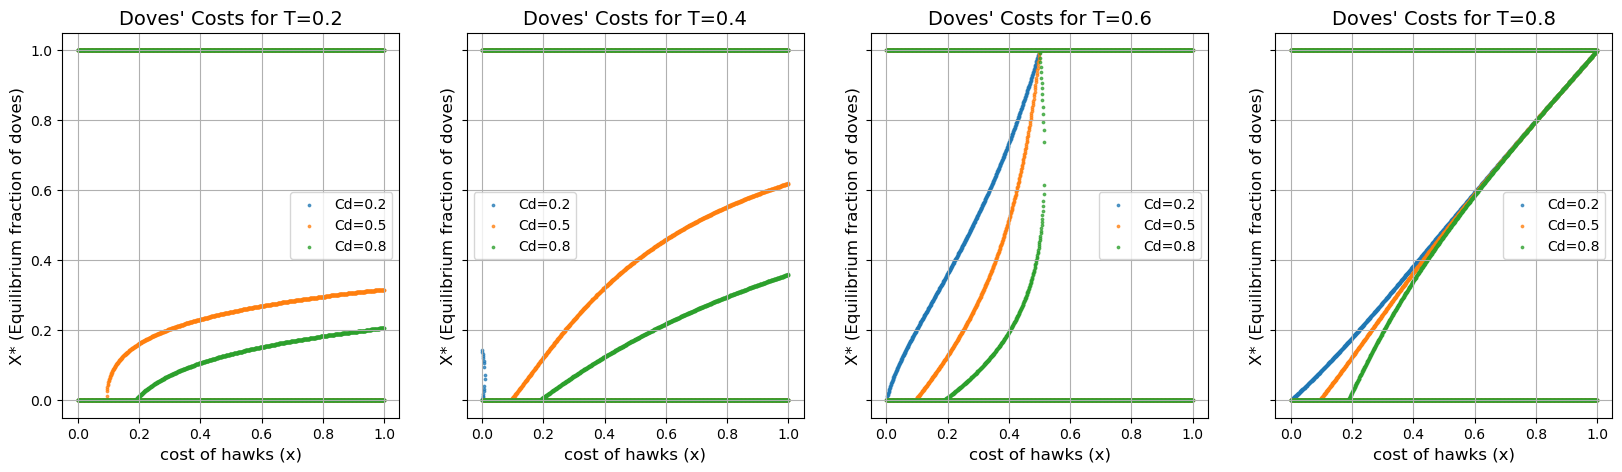

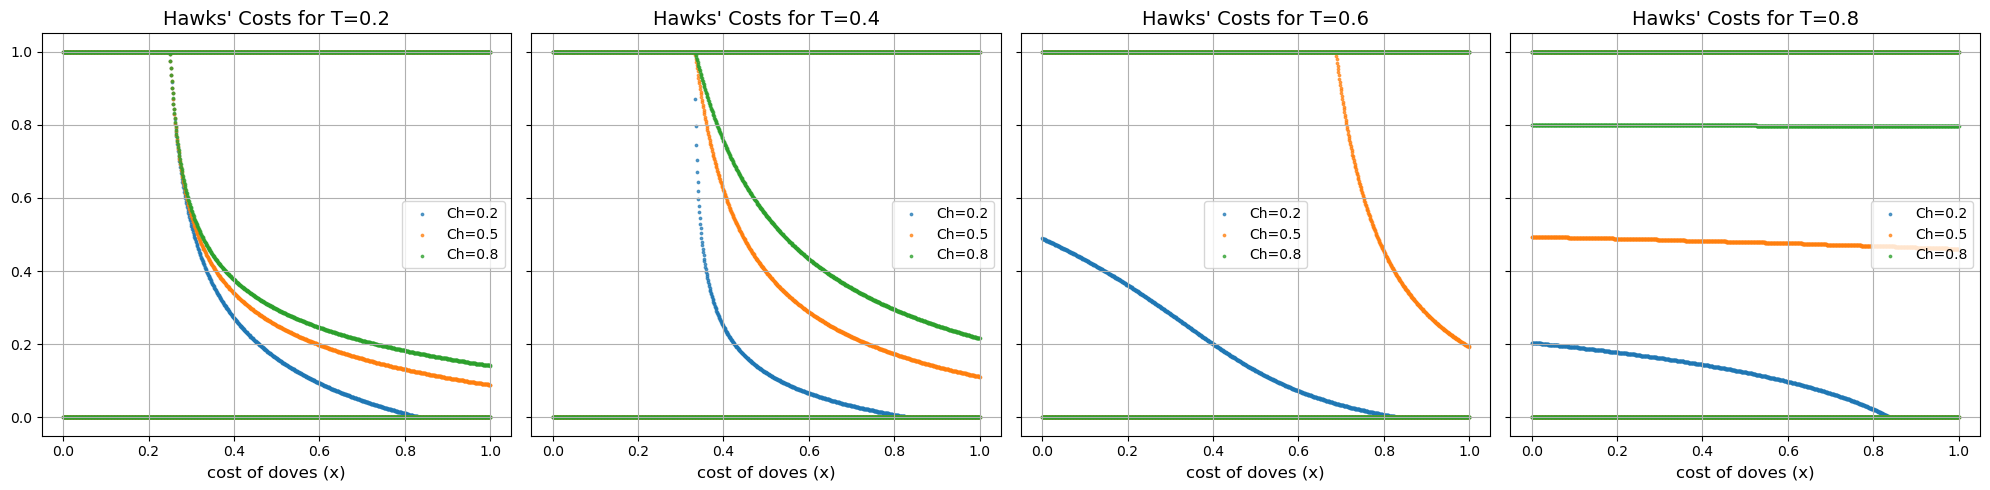

In [ ]:
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

def plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):


        #Doves
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure3A(T, c_d)
            axes[t_idx].scatter(x_as, y_as, label=Doves_Costs_labels[d_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of hawks (x)", fontsize=12)
        axes[t_idx].set_ylabel("X* (Equilibrium fraction of doves)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure3B(T, c_h)
            axes[t_idx].scatter(x_as, y_as, label=Hawks_Costs_labels[h_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of doves (x)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)

# Figure 4
Phase diagram for Hawk-Dove Game.

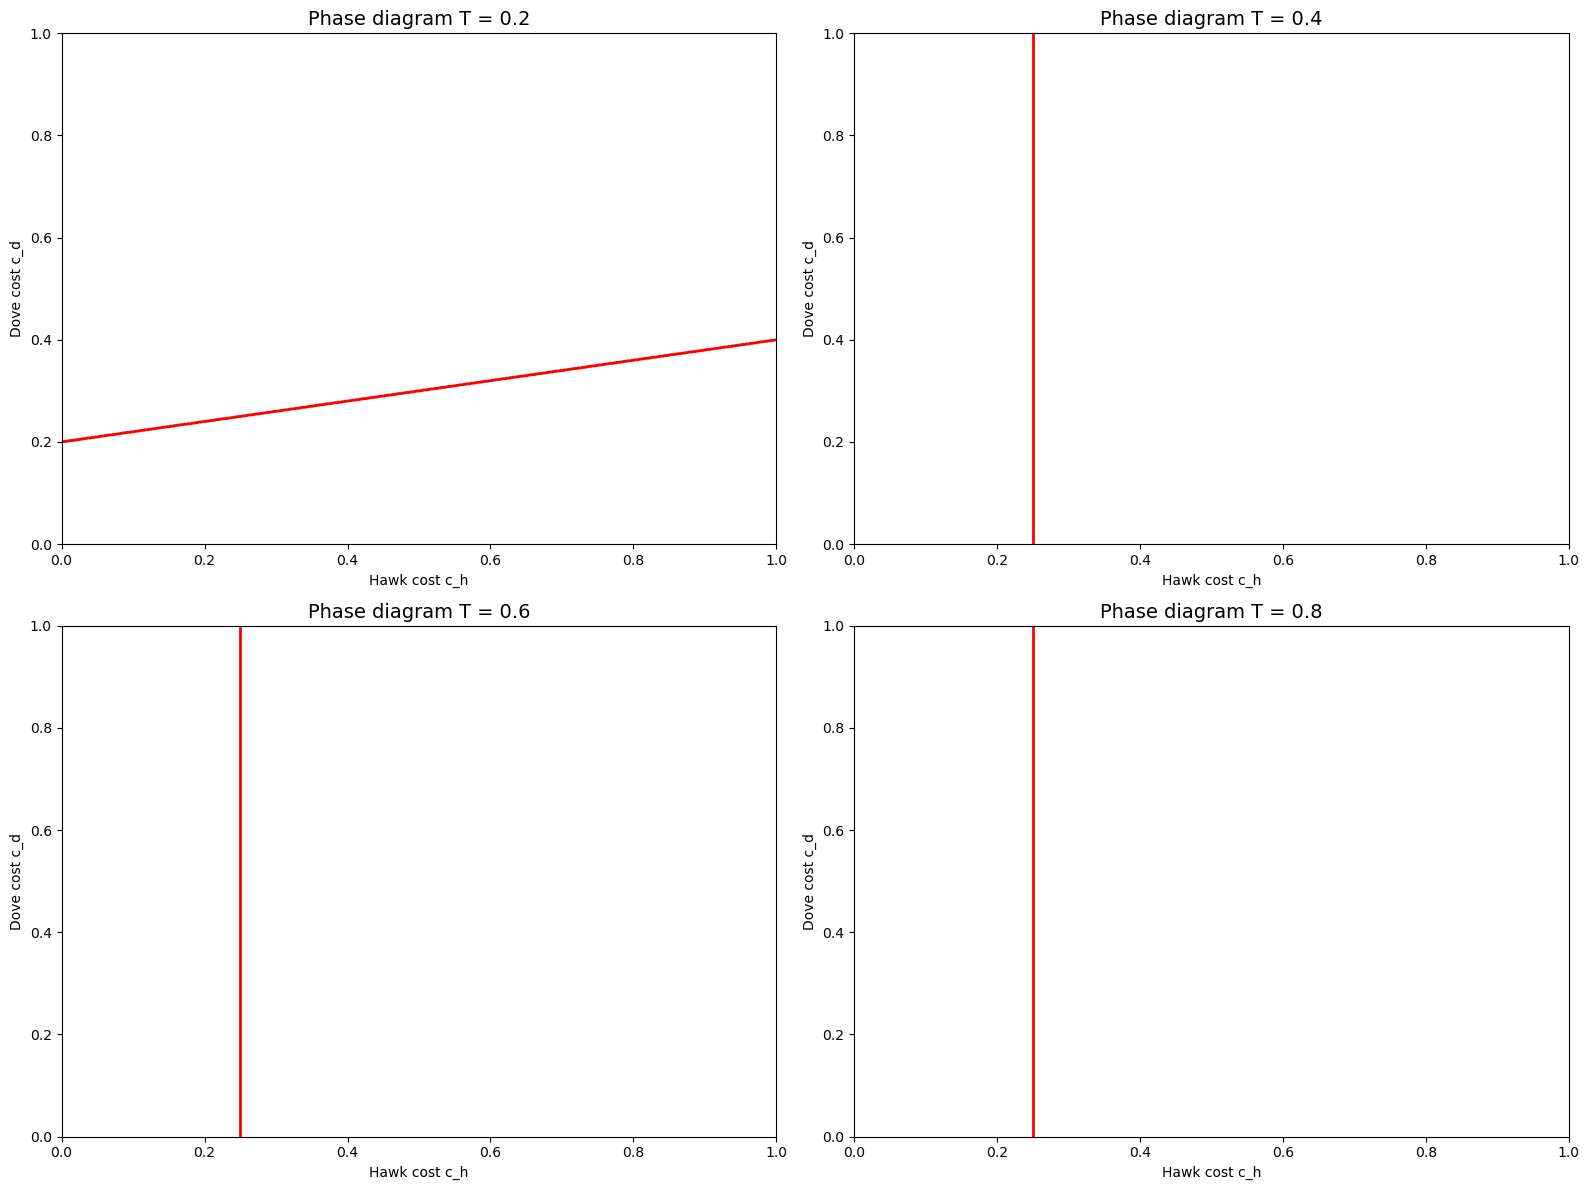

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the payoff functions
def P_H_T(amount_doves, c_h, T, N, R=1.0):
    P_H = 0
    amount_hawks = N - 1 - amount_doves
    total_hawks = amount_hawks + 1
    if amount_doves / N < T:
        P_H = (R - amount_hawks * c_h) / total_hawks
    return P_H

def P_D_T(amount_doves, c_d, T, N, R=1.0):
    P_D = 0
    amount_hawks = N - amount_doves
    if amount_doves / N >= T:
        P_D = (R - (amount_hawks * c_d)) / amount_doves
    return P_D

# Parameters
N = 5
R = 1.0
c_h_values = np.linspace(0, 1, n_steps)
c_d_values = np.linspace(0, 1, n_steps)
T_list = [0.2, 0.4, 0.6, 0.8]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, T in enumerate(T_list):
    phase_diagram = np.zeros((n_steps, n_steps), dtype=int)

    for i, c_h in enumerate(c_h_values):
        for j, c_d in enumerate(c_d_values):
            doves_can_invade = False
            hawks_can_invade = False

            # Favor 1 Hawk among Doves
            if (P_D_T(N, c_d, T, N, R) - P_H_T(N - 1, c_h, T, N, R)) < 0:
                hawks_can_invade = True

            # Favor 1 Dove among Hawks
            if (P_D_T(1, c_d, T, N, R) - P_H_T(0, c_h, T, N, R)) > 0:
                doves_can_invade = True

            if hawks_can_invade and not doves_can_invade:
                phase_diagram[i, j] = 1
            if doves_can_invade and not hawks_can_invade:
                phase_diagram[i, j] = 2
            if doves_can_invade and hawks_can_invade:
                phase_diagram[i, j] = 3

    # Visualize the boundaries for this T
    c_h_values = np.linspace(0, 1, n_steps)
    c_d_values = np.linspace(0, 1, n_steps)
    CH, CD = np.meshgrid(c_h_values, c_d_values, indexing='ij')

    region_labels = np.unique(phase_diagram)
    boundary_levels = 0.5 * (region_labels[:-1] + region_labels[1:])

    ax = axes[idx]
    CS = ax.contour(CH, CD, phase_diagram, levels=boundary_levels, colors='r', linewidths=2)
    ax.set_title(f"Phase diagram T = {T}", fontsize=14)
    ax.set_xlabel("Hawk cost c_h")
    ax.set_ylabel("Dove cost c_d")

# Adjust layout
plt.tight_layout()
plt.show()

#Finite populations
## Formulae for finite populations

Let $k$ be the number of doves in the total population.

Average fitness of hawks : $ f_H(k) = \sum_{i = 0}^{N - 1} \frac{\binom{k}{i} \binom{Z - k - 1}{N - i - 1}}{\binom{Z - 1}{N - 1}} P_H(i)$

Average fitness of doves : $ f_D(k) = \sum_{i = 0}^{N - 1} \frac{\binom{k-1}{i} \binom{Z - k}{N - i - 1}}{\binom{Z - 1}{N - 1}} P_D(i + 1)$ **research why i+1**

Gradient of selection in finite populations is given by: $ G(k) = T^+(k) - T^-(k) = \frac{k}{Z} \frac{Z - k}{Z} \tan h  (\frac{w}{2} ( f_D(k) - f_H(k)))$


In [36]:
# define the parameters
R = 1.0 #reward
N = 5 #sample size
Z = 100 #total population size
w = 100
n_steps = 100

# Average fitness of hawks
def avg_fitness_hawks(k, T, cost_hawks): #with k = nr of doves in the total population
  def payoff_hawks(nr_doves):
    # is i nr of doves or nr of hawks?
    nr_hawks = N - nr_doves
    if (nr_doves/N) < T : # NOTE TO SELF: here ze use the number of hawks/doves in the sample of size N, dus niet in de gehele populatie
       #or is i in the formula the nr of doves in both formulas?
       payoff = (R - ((nr_hawks - 1) * cost_hawks)) / nr_hawks
       return payoff
    else: return 0

  sum = 0
  for i in range(N):
    numerator = comb(k, i) * comb(Z-k-1, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_hawks(i)
  return sum

# Average fitness of doves
def avg_fitness_doves(k, T, cost_doves): #with k = nr of doves in the total population
  def payoff_doves(nr_doves):
    # is i nr of doves or nr of hawks?
    nr_hawks = N - nr_doves
    if (nr_doves/N) >= T : # NOTE TO SELF: here ze use the number of hawks/doves in the sample of size N, dus niet in de gehele populatie
       #or is i in the formula the nr of doves in both formulas?
       payoff = (R - (nr_hawks * cost_doves)) / nr_doves
       return payoff
    else: return 0

  sum = 0
  for i in range(N):
    numerator = comb(k-1, i) * comb(Z-k, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_doves(i+1)
  return sum

#gradient of selection in finite populations
def gradient_selection_finite(k, T, cost_doves, cost_hawks):
#probablility population increase T_plus
  def T_plus(k): #with k = nr of doves in the total population
    factor_1 = k/Z
    factor_2 = (Z-k)/Z
    factor_3_exponent = w * (avg_fitness_doves(k, T, cost_doves) - avg_fitness_hawks(k, T, cost_hawks))
    factor_3 = 1/(1 + math.exp((factor_3_exponent)))
    return (factor_1 * factor_2 * factor_3)

  #probablility population decrease T_min
  def T_min(k): #with k = nr of doves in the total population
    factor_1 = k/Z
    factor_2 = (Z-k)/Z
    factor_3_exponent = w * (avg_fitness_doves(k, T, cost_doves) - avg_fitness_hawks(k, T, cost_hawks))
    factor_3 = 1/(1 + math.exp((-factor_3_exponent)))
    return (factor_1 * factor_2 * factor_3)

  return (T_plus(k) - T_min(k))

In [30]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

##Fig 5
Equilibria of the N-person Hawk-Dove Game with threshold in finite populations.

Fraction of doves $k*/Z$ in the equilibrium as a function of the hawks' cost $C_{H}$ (top) and doves' cost $C_{D}$ (bottom)
- for a sample size of $N=1$ in a finite population of $Z=100$.
- Solid (dashed) points represent stable (bistable) points, whereas dashed lines represent different doves' costs: red, blue, and grey lines correspond to $C_{D} = 0.2$, $0.5$, and $0.8$ respectively.
- In the bottom panels, red blue and grey symbols represent hawks' cost  $C_{H} = 0.2$, $0.5$, and $0.8$ respectively.
- Other parameters are $R=1$, $w=1$.


In [31]:
def figure5_toprow(T, c_d):

    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []


    for index, c_h in enumerate(hawk_cost):

        x_dot = np.empty(n_steps)

        for i in range(len(dove_frequency)):
            frac_doves = dove_frequency[i]
            total_nr_doves = frac_doves * Z
            #fitness_doves = avg_fitness_doves(total_nr_doves, T, c_d) # k, T , cost_doeves
            #fitness_hawks = avg_fitness_hawks(total_nr_doves, T, c_h)
            x_dot[i] = gradient_selection_finite(total_nr_doves, T, c_d, c_h)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        hawk_cost_answer.extend([c_h] * len(equilibria))


    return fraction_dove, hawk_cost_answer

In [34]:
def figure5_bottomrow(T, c_h):

    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    fraction_dove_answer = []

    for index, c_d in enumerate(dove_cost):

        x_dot =  np.empty(n_steps)

        for i in range(len(dove_frequency)):
            frac_doves = dove_frequency[i]
            total_nr_doves = frac_doves * Z
            #fitness_doves = average_fitness_doves(N, x, c_d, T)
            #fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = gradient_selection_finite(total_nr_doves, T, c_d, c_h)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        fraction_dove_answer.extend([c_d] * len(equilibria))

    return fraction_dove, fraction_dove_answer

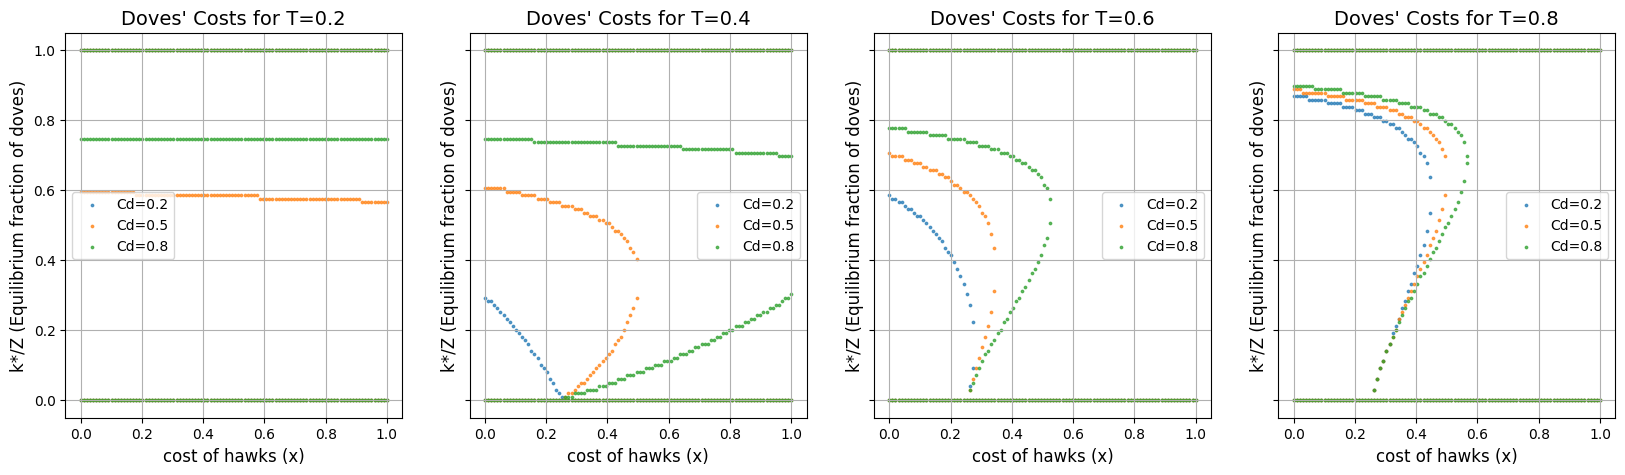

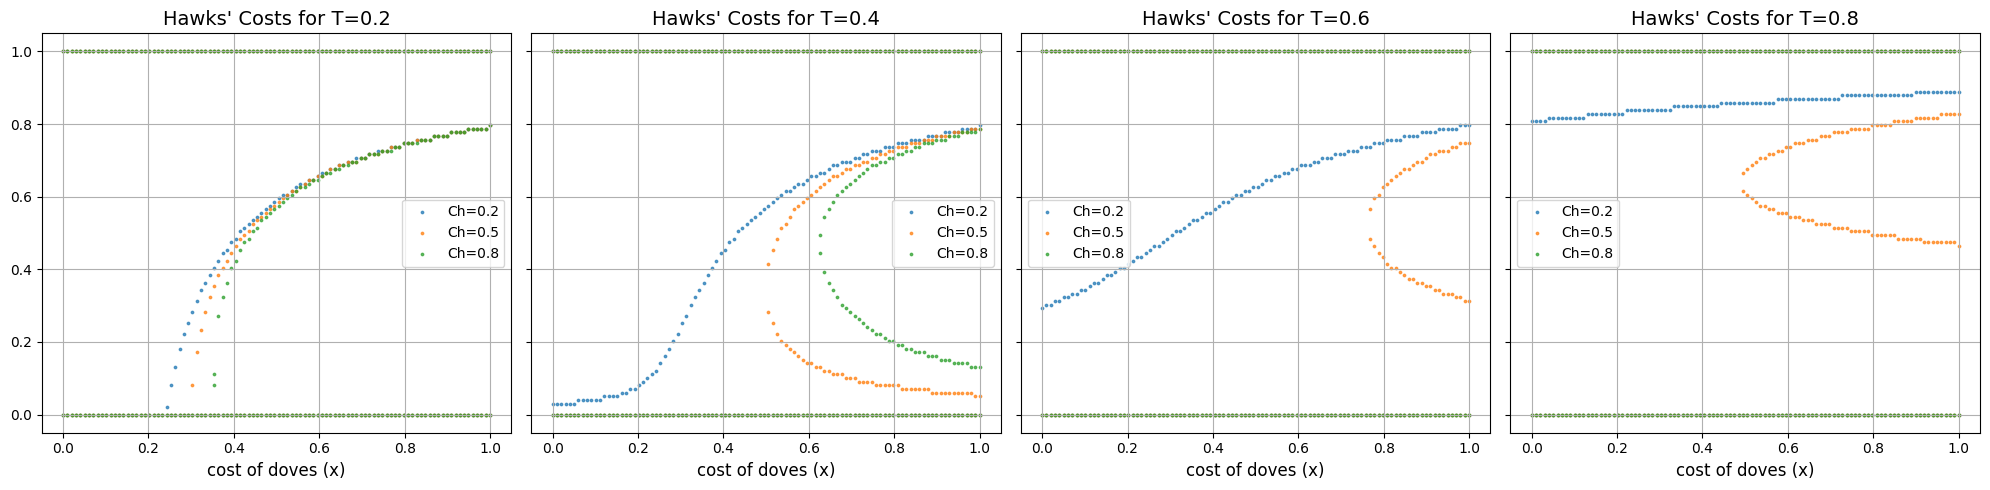

In [37]:
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

def plot_figure5_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):


        #Doves
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure5_toprow(T, c_d)
            axes[t_idx].scatter(x_as, y_as, label=Doves_Costs_labels[d_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of hawks (x)", fontsize=12)
        axes[t_idx].set_ylabel("k*/Z (Equilibrium fraction of doves)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)



    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []

    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure5_bottomrow(T, c_h)
            axes[t_idx].scatter(x_as, y_as, label=Hawks_Costs_labels[h_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of doves (x)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_figure5_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)